In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to path:", project_root)


Project root added to path: c:\Users\laksh\OneDrive\Desktop\quant-task


In [3]:
from src.metrics import sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

In [4]:
df = pd.read_csv("../data/spot_5min_features_with_regime.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)
print(df.shape)
df.head()

(3047, 25)


,index,Datetime,open,high,low,close,volume,ret_1,ret_5,ema_20,...,volume_z,sentiment_pressure,future_price,basis,delta_proxy,gamma_proxy,vega_proxy,theta_proxy,regime,regime_name
0,0,2025-11-18 05:55:00+00:00,293.299988,293.299988,293.089996,293.089996,122093.0,-0.000784,-0.000205,293.092066,...,1.292831,0.000926,293.119305,0.0001,-0.197899,0.007944,-0.000035,-0.000468,1,Sideways
1,1,2025-11-18 06:00:00+00:00,293.079987,293.200012,293.000000,293.149994,25759.0,0.000205,0.000171,293.097583,...,-0.600434,-0.000410,293.179309,0.0001,-0.186893,0.011006,-0.000043,-0.000455,2,Uptrend
2,2,2025-11-18 06:05:00+00:00,293.200012,293.299988,293.130005,293.269989,22863.0,0.000409,0.000307,293.114002,...,-0.666646,-0.000386,293.299316,0.0001,-0.169905,0.016988,-0.000087,-0.000413,2,Uptrend
3,3,2025-11-18 06:10:00+00:00,293.269989,293.410004,293.230011,293.329987,23578.0,0.000205,0.000341,293.134572,...,-0.663005,-0.000407,293.359320,0.0001,-0.151142,0.018763,-0.000112,-0.000388,2,Uptrend
4,4,2025-11-18 06:15:00+00:00,293.429993,293.589996,293.339996,293.450012,37559.0,0.000409,0.000443,293.164614,...,-0.393213,-0.000335,293.479357,0.0001,-0.127543,0.023599,-0.000108,-0.000393,2,Uptrend


In [5]:
print(df.columns)
print(df["regime_name"].value_counts())


Index(['index', 'Datetime', 'open', 'high', 'low', 'close', 'volume', 'ret_1',
       'ret_5', 'ema_20', 'ema_50', 'ema_diff', 'volatility_20',
       'volatility_100', 'hl_range', 'volume_z', 'sentiment_pressure',
       'future_price', 'basis', 'delta_proxy', 'gamma_proxy', 'vega_proxy',
       'theta_proxy', 'regime', 'regime_name'],
      dtype='object')
regime_name
Uptrend      2607
Sideways      388
Downtrend      52
Name: count, dtype: int64


In [6]:
df["ema_5"] = df["close"].ewm(span=5, adjust=False).mean()
df["ema_15"] = df["close"].ewm(span=15, adjust=False).mean()

In [7]:
df["ema_cross_up"] = (df["ema_5"] > df["ema_15"]) & (df["ema_5"].shift(1) <= df["ema_15"].shift(1))
df["ema_cross_down"] = (df["ema_5"] < df["ema_15"]) & (df["ema_5"].shift(1) >= df["ema_15"].shift(1))

In [8]:
df["signal"] = 0
df.loc[
    (df["ema_cross_up"]) & (df["regime_name"] == "Uptrend"),
    "signal"
] = 1
df.loc[
    (df["ema_cross_down"]) & (df["regime_name"] == "Downtrend"),
    "signal"
] = -1

In [9]:
df["trade_signal"] = df["signal"].shift(1)
df["trade_signal"] = df["trade_signal"].fillna(0)

In [10]:
df["position"] = 0
current_pos = 0
for i in range(len(df)):
    if df.loc[i, "trade_signal"] == 1:
        current_pos = 1
    elif df.loc[i, "trade_signal"] == -1:
        current_pos = -1
    df.loc[i, "position"] = current_pos

In [11]:
df["market_ret"] = df["close"].pct_change()
df["strategy_ret"] = df["position"].shift(1) * df["market_ret"]
df["strategy_ret"] = df["strategy_ret"].fillna(0)

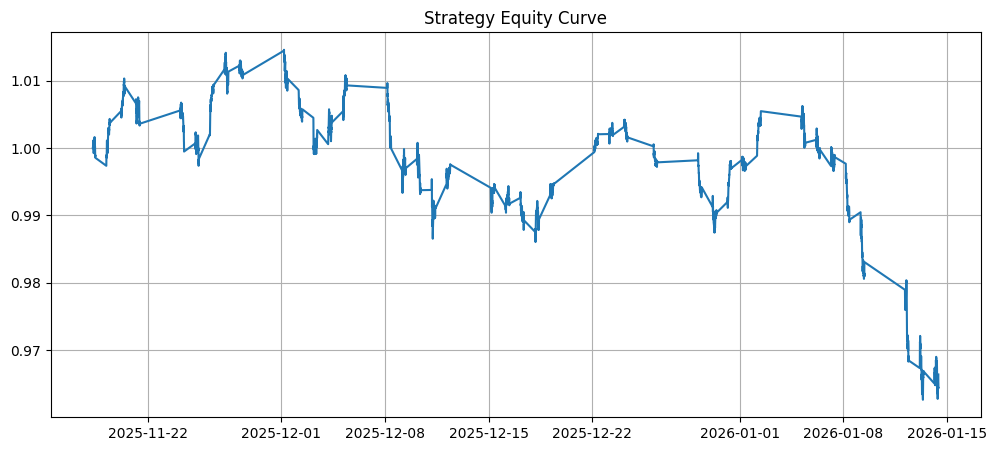

In [12]:
df["equity_curve"] = (1 + df["strategy_ret"]).cumprod()
plt.figure(figsize=(12,5))
plt.plot(df["Datetime"], df["equity_curve"])
plt.title("Strategy Equity Curve")
plt.grid(True)
plt.show()

In [13]:
split = int(len(df) * 0.7)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()
print("Train size:", len(train))
print("Test size:", len(test))

Train size: 2132
Test size: 915


In [14]:
df[["Datetime","close","ema_5","ema_15","regime_name","trade_signal","position"]].tail(20)

,Datetime,close,ema_5,ema_15,regime_name,trade_signal,position
3027,2026-01-14 08:20:00+00:00,290.339996,290.587667,291.003478,Uptrend,0.0,1
3028,2026-01-14 08:25:00+00:00,290.250000,290.475111,290.909293,Uptrend,0.0,1
3029,2026-01-14 08:30:00+00:00,290.299988,290.416737,290.833130,Uptrend,0.0,1
3030,2026-01-14 08:35:00+00:00,290.399994,290.411156,290.778988,Uptrend,0.0,1
3031,2026-01-14 08:40:00+00:00,290.500000,290.440771,290.744114,Uptrend,0.0,1
3032,2026-01-14 08:45:00+00:00,290.410004,290.430515,290.702350,Uptrend,0.0,1
3033,2026-01-14 08:50:00+00:00,290.010010,290.290347,290.615808,Sideways,0.0,1
3034,2026-01-14 08:55:00+00:00,290.100006,290.226900,290.551333,Uptrend,0.0,1
3035,2026-01-14 09:00:00+00:00,290.250000,290.234600,290.513666,Uptrend,0.0,1
3036,2026-01-14 09:05:00+00:00,290.500000,290.323067,290.511958,Uptrend,0.0,1


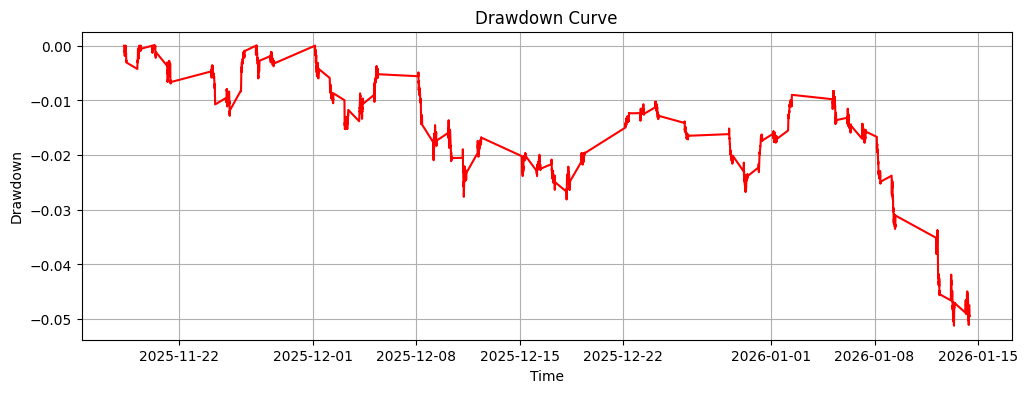

In [15]:
df["cum_max"] = df["equity_curve"].cummax()
df["drawdown"] = df["equity_curve"] / df["cum_max"] - 1

plt.figure(figsize=(12,4))
plt.plot(df["Datetime"], df["drawdown"], color="red")
plt.title("Drawdown Curve")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()

In [16]:
trades = []
current_pos = 0
entry_price = 0
entry_time = None

for i in range(len(df)):
    if current_pos == 0:
        if df.loc[i, "position"] == 1:
            current_pos = 1
            entry_price = df.loc[i, "open"]
            entry_time = df.loc[i, "Datetime"]
        elif df.loc[i, "position"] == -1:
            current_pos = -1
            entry_price = df.loc[i, "open"]
            entry_time = df.loc[i, "Datetime"]

    elif current_pos == 1:
        if df.loc[i, "position"] != 1:
            exit_price = df.loc[i, "open"]
            exit_time = df.loc[i, "Datetime"]
            pnl = (exit_price - entry_price) / entry_price
            trades.append(("LONG", entry_time, exit_time, pnl))
            current_pos = 0

    elif current_pos == -1:
        if df.loc[i, "position"] != -1:
            exit_price = df.loc[i, "open"]
            exit_time = df.loc[i, "Datetime"]
            pnl = (entry_price - exit_price) / entry_price
            trades.append(("SHORT", entry_time, exit_time, pnl))
            current_pos = 0

trades_df = pd.DataFrame(trades, columns=["type", "entry_time", "exit_time", "pnl"])
trades_df["duration"] = (trades_df["exit_time"] - trades_df["entry_time"]).dt.total_seconds() / 60

print("Total trades:", len(trades_df))
trades_df.head()

Total trades: 14


,type,entry_time,exit_time,pnl,duration
0,LONG,2025-11-18 06:05:00+00:00,2025-12-10 05:25:00+00:00,-0.002387,31640.0
1,SHORT,2025-12-10 05:30:00+00:00,2025-12-10 07:55:00+00:00,-0.000103,145.0
2,LONG,2025-12-10 08:00:00+00:00,2025-12-11 04:10:00+00:00,-0.004240,1210.0
3,SHORT,2025-12-11 04:15:00+00:00,2025-12-11 04:45:00+00:00,-0.003126,30.0
4,LONG,2025-12-11 04:50:00+00:00,2025-12-15 03:50:00+00:00,0.005168,5700.0


In [17]:
returns = df["strategy_ret"]
equity = df["equity_curve"]

total_return = equity.iloc[-1] - 1
sharpe = sharpe_ratio(returns)
sortino = sortino_ratio(returns)
mdd = max_drawdown(equity)
calmar = calmar_ratio(equity, returns)

wins = trades_df[trades_df["pnl"] > 0]
losses = trades_df[trades_df["pnl"] <= 0]

win_rate = len(wins) / len(trades_df) if len(trades_df) > 0 else 0
profit_factor = wins["pnl"].sum() / abs(losses["pnl"].sum()) if len(losses) > 0 else np.nan
avg_duration = trades_df["duration"].mean()

metrics = {
    "Total Return": total_return,
    "Sharpe": sharpe,
    "Sortino": sortino,
    "Calmar": calmar,
    "Max Drawdown": mdd,
    "Win Rate": win_rate,
    "Profit Factor": profit_factor,
    "Avg Trade Duration (min)": avg_duration,
    "Total Trades": len(trades_df)
}

pd.Series(metrics)


Total Return                  -0.033601
Sharpe                        -2.979979
Sortino                       -3.921450
Calmar                        -0.656278
Max Drawdown                  -0.051199
Win Rate                       0.285714
Profit Factor                  0.348261
Avg Trade Duration (min)    5750.714286
Total Trades                  14.000000
dtype: float64

In [18]:
split = int(len(df) * 0.7)

test = df.iloc[split:].copy()

test_equity = (1 + test["strategy_ret"]).cumprod()
test_returns = test["strategy_ret"]

test_total_return = test_equity.iloc[-1] - 1
test_sharpe = sharpe_ratio(test_returns)
test_sortino = sortino_ratio(test_returns)
test_mdd = max_drawdown(test_equity)
test_calmar = calmar_ratio(test_equity, test_returns)

test_metrics = {
    "Test Total Return": test_total_return,
    "Test Sharpe": test_sharpe,
    "Test Sortino": test_sortino,
    "Test Calmar": test_calmar,
    "Test Max Drawdown": test_mdd
}

pd.Series(test_metrics)


Test Total Return   -0.027492
Test Sharpe         -7.560681
Test Sortino        -9.490314
Test Calmar         -0.635280
Test Max Drawdown   -0.043276
dtype: float64

In [19]:
plt.figure(figsize=(12,5))
plt.plot(df["Datetime"], df["equity_curve"])
plt.title("Strategy Equity Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("../plots/equity_curve.png", dpi=200)
plt.close()

plt.figure(figsize=(12,4))
plt.plot(df["Datetime"], df["drawdown"], color="red")
plt.title("Drawdown Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("../plots/drawdown_curve.png", dpi=200)
plt.close()

print("Saved plots to plots/")

Saved plots to plots/


In [20]:
trades_df.to_csv("../results/trades.csv", index=False)
print("Saved trades to results/trades.csv")

Saved trades to results/trades.csv


In [21]:
metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
metrics_df.to_csv("../results/strategy_metrics_full.csv")

test_metrics_df = pd.DataFrame.from_dict(test_metrics, orient="index", columns=["Value"])
test_metrics_df.to_csv("../results/strategy_metrics_test.csv")

print("Saved metrics to results/")


Saved metrics to results/
